In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 10

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
113.803052 seconds (996.50 M allocations: 42.465 GiB, 10.35% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_150.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_300.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);
num_images = length(images)

# Compute true and perturbed opportunities
@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);

# 
@time collects = compute_collects_by_number(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

  0.261448 seconds (692.84 k allocations: 36.790 MiB, 5.50% gc time)
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Computing opportunities for perturbed orbit: 6
Computing opportunities for perturbed orbit: 7
Computing opportunities for perturbed orbit: 8
Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
156.888757 seconds (1.86 G allocations: 195.896 GiB, 18.03% gc time)
  0.177052 seconds (397.93 k allocations: 20.542 MiB, 4.06% gc time)
125 out of 150 images have collection opportunities.


In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

[1.01465, 5.38971, 11.0529, 14.7419, 19.7907, 26.2849, 30.4437, 36.0414, 39.8424, 43.1747, 51.5945, 52.341, 60.761, 64.3599, 68.4111, 74.3238, 80.6393, 78.8935, 89.2742, 101.637, 91.9614, 104.909, 107.747, 113.781]
[3.08929, 9.46609, 15.8702, 20.2006, 24.4774, 31.2333, 33.7762, 39.677, 44.607, 47.5765, 55.0489, 57.2578, 63.678, 68.7247, 69.8037, 78.4837, 85.4178, 85.2887, 93.619, 102.484, 96.2985, 110.569, 111.995, 113.687]
[3.59762, 6.33451, 5.97801, 7.80939, 6.13564, 6.45909, 4.02055, 6.68694, 7.42858, 6.57233, 4.15741, 8.2892, 4.47738, 5.7534, 7.40326, 7.30671, 6.85966, 12.3504, 6.95279, 6.41626, 7.11538, 9.07275, 11.3466, 17.527]
[2, 0, 0, 4, 0, 3, 0, 3, 0, 4, 4, 0, 0, 1, 0, 1, 0, 0, 4, 2, 15, 0, 0, 1]


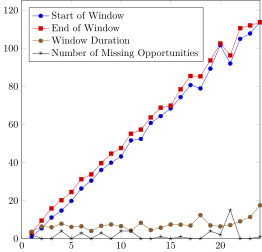

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [6]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

  5.812314 seconds (58.09 M allocations: 1.968 GiB, 12.15% gc time)
Total planning reward: 125.0
Number of images collected: 125/150, 83.33333333333334
Number of feasible images collected: 125/125, 100.0


In [7]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

Academic license - for non-commercial use only
Optimize a model with 45823 rows, 4345 columns and 95741 nonzeros
Variable types: 0 continuous, 4345 integer (4345 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 4345 integer (4345 binary)

Root relaxation: objective 1.250000e+02, 30 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     125.0000000 4345.00000  3376%     -    0s
     0     0          -    0       125.00000  125.00000  0.00%     -    0s

Explored 0 nodes (64 simplex iterations) in 0.13 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 125 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.250000000000e+02, best bound 1.250000000000e+02,

In [8]:
# MDP Planning
@time path, reward, image_list = sp_mdp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

138.669897 seconds (37.68 M allocations: 1.394 GiB, 0.44% gc time)
Total planning reward: Collect(Ptr: 4745051792, Orbit: 0, Image: 4707833104, Opportunity: 4707073600, Start: Epoch(2019-01-01T00:09:39.000Z), End: Epoch(2019-01-01T00:09:44.000Z))
Number of images collected: 124/150, 82.66666666666667
Number of feasible images collected: 124/125, 99.2


In [297]:

function mdp_construct_actions(collects::Array{Collect, 1}, constraint_list::Array{Function, 1}; horizon=0::Real)
    
    # Sort Collects to ensure they are in time-asecnding order
    sort!(collects, by = x -> x.sow)

    # Initialize validate transition graph
    actions = Dict{Epoch, Array{Collect, 1}}()

    for start_collect in collects
        # List of valid edges/transitions for start_collect
        actions[start_collect.sow] = Array{Collect, 1}[]
        
        for end_collect in collects
            # Decide to insert edge
            if (start_collect == end_collect || 
                start_collect.image == end_collect.image ||
                end_collect.sow < start_collect.eow)
                # Skip insertion if same collect, image, or starts before the current
                # collection ends (no instantaneous manevers)
                continue
            elseif horizon > 0 && end_collect.sow > (start_collect.eow + horizon)
                # Since we know collects are sorted we can break building the
                # transition grarph if the distance from the next to the next start
                # is greater than the look-ahead horizon
                break
            else
                # Set transition valid by default
                valid_transition = true

                for constraint in constraint_list
                    # If not valid transition break early
                    if valid_transition == false
                        continue
                    end

                    # Use logical and to evaulate path feasibility on graph
                    valid_transition = valid_transition && constraint(start_collect, end_collect)
                end

                if valid_transition
                    push!(actions[start_collect.sow], end_collect)
                end
            end
        end
    end
    
    return actions
end

function mdp_image_lookup(image_list::Array{Image,1})
    image_lookup = Dict{Int64, Image}()
    
    for (i, img) in enumerate(image_list)
        image_lookup[i] = img
    end
    
    return image_lookup
end

function compute_collect_probability(collects::Array{Collect}, opportunities::Array{Array{Opportunity,1},1})
    collect_probability = Dict{Collect, Float64}()
    for col in collects
        num_present, num_missing = 0, 0
        for opportunity_list in opportunities
            if length(filter(x -> x.image == col.image && x.sow <= col.sow && x.eow >= col.eow, opportunity_list)) == 1
                num_present += 1
            else
                num_missing += 1
            end
        end
        
        collect_probability[col] = num_present/(num_missing+num_present)
    end
    
    return collect_probability
end

mutable struct MDPState
    time::Epoch
    images::Array{Bool, 1}
end

function MDPState(epc::Epoch, image_list::Array{Image,1})    
    return MDPState(epc, falses(length(image_list)))
end

function mdp_reward(s::MDPState, image_lookup::Dict{<:Integer, Image})
    r = 0.0
    for (i, img) in enumerate(s.images)
        if img
            r += image_lookup[img].reward
        end
    end
    
    return r
end

function mdp_future_states(state::MDPState, action::Collect, int_lookup::Dict{Image, <:Integer})
    failure      = MDPState(state.time, copy(state.images))
    failure.time = action.sow
    
    success = MDPState(failure.time, copy(failure.images))
    success.images[int_lookup[action.image]] = true
    
    return MDPState[success, failure]
end

function mdp_transition(sp::MDPState, s::MDPState, a::Collect, collect_probabilities::Dict{Collect, Float64})
    p = collect_probabilities[a]
    
    return p
end

function mdp_select_action(s::MDPState, d::Integer, actions::Dict{Epoch, Array{Collect, 1}}, 
                            image_lookup::Dict{<:Integer, Image}, int_lookup::Dict{Image, <:Integer},
                            collect_probabilities::Dict{Collect, Float64};
                            gamma::Real=0.7)

    if d == 0
        return nothing, 0
    end
    
    as, vs = nothing, -Inf
    
#     if length(actions[s.time]) == 0
#         println("Num actions: $(length(actions[s.time]))")
#         println("$(s.time)")
#         println("$(actions[s.time])")
#         for ac in actions[s.time]
#             println(ac)
#         end
#     end
    for a in actions[s.time]
        v = mdp_reward(s, image_lookup)
        
        for sp in mdp_future_states(s, a, int_lookup)
            ap, vp = mdp_select_action(sp, d-1, actions, image_lookup, int_lookup, collect_probabilities, gamma=gamma)
            v      = v + gamma*mdp_transition(sp, s, a, collect_probabilities)*vp
        end
        
        if v > vs
            as, vs = a, v
        end
    end
    
    return as, vs
end

function mdp_transition_state(s::MDPState, a::Collect, int_lookup::Dict{Image, <:Integer})
    sn = MDPState(a.sow, deepcopy(s.images))
    
    # Set state to collected
    sn.images[int_lookup[a.image]] = true
    
    return sn
end

function mdp_forward_search(collects::Array{Collect, 1}, constraint_list, 
                            images::Array{Image,1}, collect_probabilities; 
                            horizon=0::Real, search_depth=5::Integer, gamma=0.7::Real)
    # Compute action set
    actions = mdp_construct_actions(collects, Function[constraint_agility_single_axis], horizon=7200.0)
    
    # Compute Initial start
    s_init = MDPState(findmin(collect(keys(actions)))[1], images)
    
    # Create lookups
    image_lookup = mdp_image_lookup(images)
    int_lookup = Dict{Image, Int64}([v => k for (k,v) in image_lookup])
    
    # Compute initial action
    a, v = mdp_select_action(s_init, search_depth, actions, image_lookup, int_lookup, cp, gamma=0.7)
#     println("Optimal action: $a")
    s    = mdp_transition_state(s_init, a, int_lookup)
    
    plan = Union{Collect, Nothing}[a]
    
    # Perform forward search 
    while true
        a, v = mdp_select_action(s, search_depth, actions, image_lookup, int_lookup, collect_probabilities, gamma=gamma)  
        
        if a == nothing
            # Exit early if no possible action left
            break
        end
#         println("State: $s\nReward:$v\nOptimal Action: $a\n")
        
        # Update State
        push!(plan, a)
        
        # Transition state
        s = mdp_transition_state(s, a, int_lookup)
    end
    
    # Compute plan reward
    reward = 0
    image_list = Image[]
    
    num_pos = 0
    num_neg = 0
    
    for (i, img_state) in enumerate(s.images)
        if img_state
            img     = image_lookup[i]
            reward += img.reward
            push!(image_list, img)
            num_pos += 1
        else
            num_neg += 1
        end
    end
    
    println("Number of all images: $(length(s.images)), Collected: $num_pos, Missed: $num_neg")
    
    return plan, reward, image_list
end

mdp_forward_search (generic function with 1 method)

In [298]:
# Test MDP Forward Search Solution
@time actions = mdp_construct_actions(collects, Function[constraint_agility_single_axis], horizon=1800.0);

cp = compute_collect_probability(collects, perturbed_opportunities);

  3.130545 seconds (37.06 M allocations: 1.159 GiB, 8.02% gc time)


In [301]:
# @time a, v = mdp_select_action(s_init, 1, actions, image_lookup, int_lookup, cp, gamma=0.7)

@time path, reward, image_list = mdp_forward_search(collects, Function[constraint_agility_single_axis], 
                                                    images, cp,
                                                    horizon=7200, gamma=0.7, search_depth=1)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

Number of all images: 150, Collected: 125, Missed: 25
  3.332858 seconds (38.71 M allocations: 1.289 GiB, 8.17% gc time)
Total planning reward: 125.0
Number of images collected: 125/150, 83.33333333333334
Number of feasible images collected: 125/125, 100.0


In [251]:
# Compute action set
actions = mdp_construct_actions(collects, Function[constraint_agility_single_axis], horizon=1800.0)

# Compute Initial start
s_init      = MDPState(findmin(collect(keys(actions)))[1], images)

# Create lookups
image_lookup = mdp_image_lookup(images)
int_lookup = Dict{Image, Int64}([v => k for (k,v) in image_lookup])

# # Compute initial action
# a, v = mdp_select_action(s_init, 2, actions, image_lookup, int_lookup, cp, gamma=0.7)
# s    = mdp_transition_state(s_init, a, int_lookup)

# plan = Union{Collect, Nothing}[a]

# # # Perform forward search 
# # for i in 1:16
# #     a, v = mdp_select_action(s, 2, actions, image_lookup, int_lookup, cp, gamma=0.7)  

# #     if a == nothing
# #         # Exit early if no possible action left
# #         break
# #     end
# # #         println("State: $s\nReward:$v\nOptimal Action: $a\n")

# #     # Update State
# #     push!(plan, a)

# #     # Transition state
# #     s = mdp_transition_state(s, a, int_lookup)
# # end

# # println(a)

# println(s)
# println(length(actions[s.time]))
a, v = mdp_select_action(s, 1, actions, image_lookup, int_lookup, cp, gamma=0.7)  

println(a)

Collect(Ptr: 4745093744, Orbit: 0, Image: 4707678960, Opportunity: 4697906864, Start: Epoch(2019-01-01T01:15:03.000Z), End: Epoch(2019-01-01T01:15:08.000Z))


In [235]:
for a in path
    println(a)
end

Collect(Ptr: 4745052736, Orbit: 0, Image: 4707788368, Opportunity: 4705667120, Start: Epoch(2019-01-01T00:16:46.000Z), End: Epoch(2019-01-01T00:16:51.000Z))
Collect(Ptr: 4745055056, Orbit: 0, Image: 4707780208, Opportunity: 4704842256, Start: Epoch(2019-01-01T00:18:26.000Z), End: Epoch(2019-01-01T00:18:31.000Z))
Collect(Ptr: 4745056416, Orbit: 0, Image: 4707830608, Opportunity: 4706590784, Start: Epoch(2019-01-01T00:19:13.000Z), End: Epoch(2019-01-01T00:19:18.000Z))
Collect(Ptr: 4745057376, Orbit: 0, Image: 4707788176, Opportunity: 4705673200, Start: Epoch(2019-01-01T00:20:21.000Z), End: Epoch(2019-01-01T00:20:26.000Z))
Collect(Ptr: 4745058416, Orbit: 0, Image: 4707834448, Opportunity: 4707811744, Start: Epoch(2019-01-01T00:28:38.000Z), End: Epoch(2019-01-01T00:28:43.000Z))
Collect(Ptr: 4745059856, Orbit: 0, Image: 4707785776, Opportunity: 4705420240, Start: Epoch(2019-01-01T00:30:30.000Z), End: Epoch(2019-01-01T00:30:35.000Z))
Collect(Ptr: 4745060816, Orbit: 0, Image: 4707784144, Oppo